In [3]:
# import library
import numpy as np 
import pandas as pd
import re
import os

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

from functools import partial
from keras import metrics

In [4]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
MAX_NB_WORDS = 6000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [5]:
# open dataset,save on dataframe
df = pd.read_csv("just_stemming3.csv",encoding="ISO-8859-1")

# membuka data slang (data yang akan dibenarkan)
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())
    
df.head()

,text,label
0,itu konflik rebut tanah,0
1,bisa tidak palestina taat cara kaffah dalam is...,0
2,kalau palestina rohingya lebih ke konflik poli...,1
3,teroris islam itu gejala baru utama bagai imba...,1
4,paling sedikit gregetan saya turun karena kamu...,2


In [6]:
# delete data label netral
df = df[df.label != 0]

In [7]:
df

,text,label
2,kalau palestina rohingya lebih ke konflik poli...,1
3,teroris islam itu gejala baru utama bagai imba...,1
4,paling sedikit gregetan saya turun karena kamu...,2
5,tolong negara negara arab atau lain harus tega...,1
7,memang konflik israel palestina memang kompleks,1
...,...,...
1399,konflik israel palestina urus mereka sedang ap...,1
1400,konflik antara israel palestina ini jelas buka...,1
1401,target gencat senjata permanen,1
1402,bukan masalah tidak support palestine atau bag...,1


In [8]:
df.loc[df['label'] == 2, 'label'] = 0

1    688
0    346
Name: label, dtype: int64


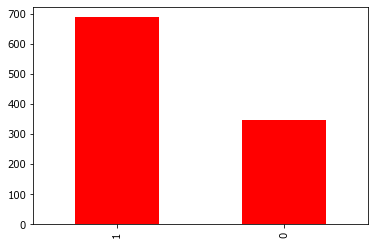

In [9]:
# menghitung Label sentimen (menampilkan tabel pembagian label sentimen)
labels = df.label
labels_count = labels.value_counts()
labels_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(labels.value_counts())

In [10]:
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [11]:
print('Found %d unique words.' % len(word_index))

Found 2458 unique words.


In [12]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [13]:
# Prepare to y as label
y = df["label"]

In [14]:
classes = ['0', '1']

In [15]:
# Membuka dataset yg telah di panggil di file local
# with open('pengujian/final/split_dataset/datset60.pickle', 'rb') as f:
#     X_train80, X_test80, y_train80, y_test80 = pickle.load(f)

In [16]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [17]:
# Use GloVe as Word Embedding
hits = 0
misses = 0
index = []
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [18]:
# test = embeddings_index.get("netizen")
# test

In [19]:
# jumlah kata yg berhasil di embedding
#hits

In [20]:
# jumlah kata yg miss tidak ada dalam vector glove
#misses

In [21]:
# kata-kataa yang tidak berhasil di bobot
#index

In [22]:
# Embedding layer with glove
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True)

In [23]:
# model 1
# Create Model CNN
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [24]:
# Train Model
cnn_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            122950    
                                                                 
 conv1d (Conv1D)             (None, 50, 64)            16064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 64)            0         
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1600)              0         
                                                        

In [25]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20, stratify=y)

In [26]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
30/30 [==============================] - 2s 29ms/step - loss: 0.6892 - accuracy: 0.6215 - val_loss: 0.6040 - val_accuracy: 0.6731
Epoch 2/10
30/30 [==============================] - 0s 16ms/step - loss: 0.6266 - accuracy: 0.6591 - val_loss: 0.5972 - val_accuracy: 0.6827
Epoch 3/10
30/30 [==============================] - 1s 17ms/step - loss: 0.5879 - accuracy: 0.6946 - val_loss: 0.5817 - val_accuracy: 0.6923
Epoch 4/10
30/30 [==============================] - 1s 17ms/step - loss: 0.5734 - accuracy: 0.7032 - val_loss: 0.5777 - val_accuracy: 0.6635
Epoch 5/10
30/30 [==============================] - 0s 13ms/step - loss: 0.5356 - accuracy: 0.7409 - val_loss: 0.5749 - val_accuracy: 0.7019
Epoch 6/10
30/30 [==============================] - 0s 13ms/step - loss: 0.5172 - accuracy: 0.7441 - val_loss: 0.5700 - val_accuracy: 0.7115
Epoch 7/10
30/30 [==============================] - 0s 16ms/step - loss: 0.5023 - accuracy: 0.7505 - val_loss: 0.5574 - val_accuracy: 0.7019
Epoch 8/10
30

CNN Accuracy: 0.7596153846153846


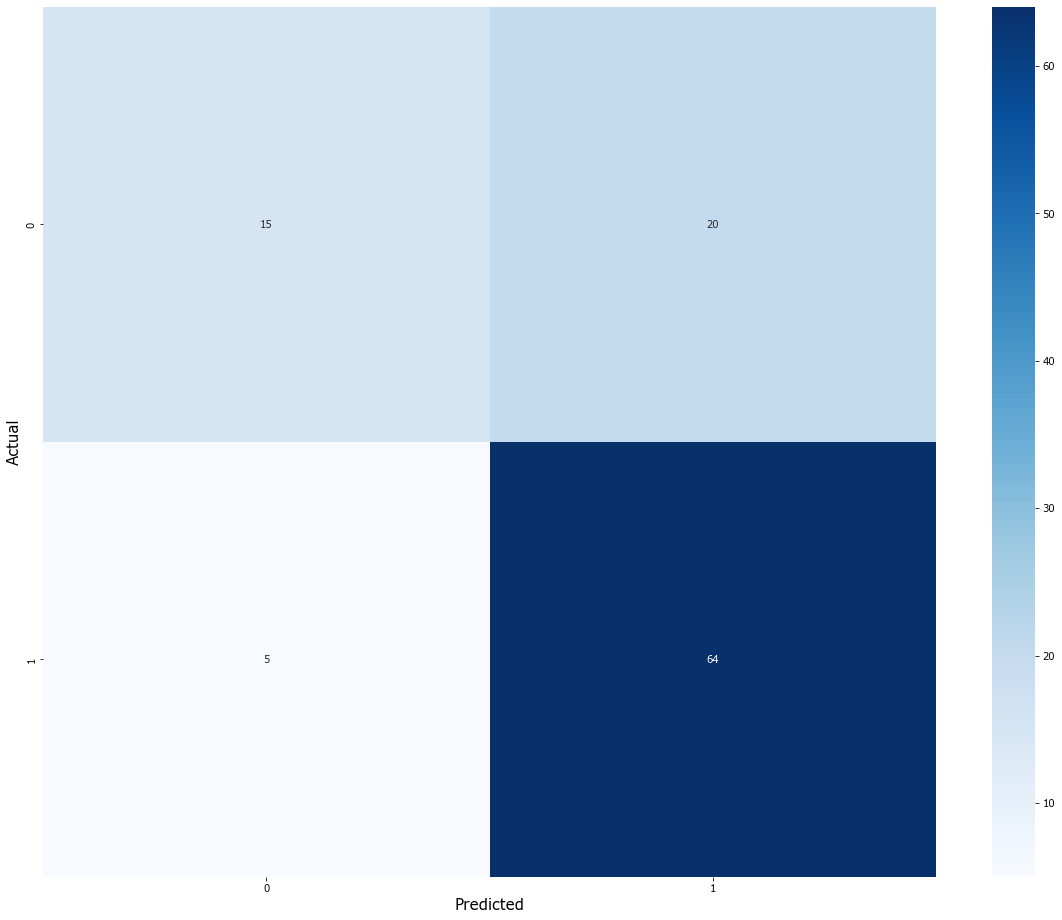

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test,ypred.round())
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test,ypred.round())
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [28]:
cnn_cn

array([[15, 20],
       [ 5, 64]], dtype=int64)

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred.round(),target_names= classes))

              precision    recall  f1-score   support

           0       0.75      0.43      0.55        35
           1       0.76      0.93      0.84        69

    accuracy                           0.76       104
   macro avg       0.76      0.68      0.69       104
weighted avg       0.76      0.76      0.74       104



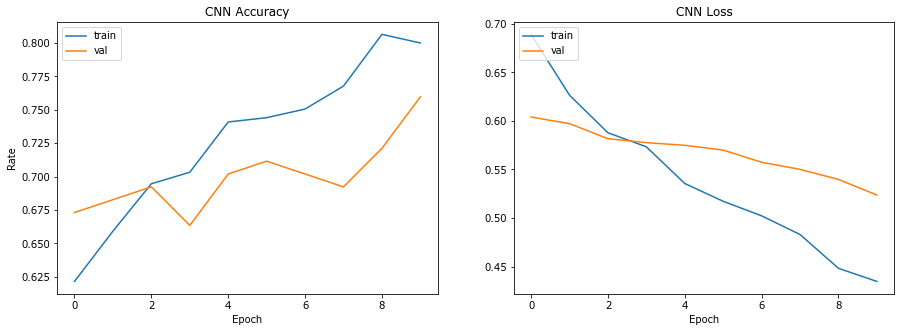

In [30]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [ ]:
# word cloud